In [ ]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

# 1. Wrangle Data

## 1.2. Import

In [ ]:
# Import 
import pandas as pd
df = pd.read_csv(DATA_PATH+'elections/bread_peace_voting.csv', index_col='Year')

## EDA

In [ ]:
df

Incumbent Party Candidate  ... Incumbent Party Vote Share
Year                            ...                           
1952                 Stevenson  ...                      44.60
1956                Eisenhower  ...                      57.76
1960                     Nixon  ...                      49.91
1964                   Johnson  ...                      61.34
1968                  Humphrey  ...                      49.60
1972                     Nixon  ...                      61.79
1976                      Ford  ...                      48.95
1980                    Carter  ...                      44.70
1984                    Reagan  ...                      59.17
1988                 Bush, Sr.  ...                      53.94
1992                 Bush, Sr.  ...                      46.55
1996                   Clinton  ...                      54.74
2000                      Gore  ...                      50.27
2004                 Bush, Jr.  ...                      51.24
2008                    McCain  ...                      46.32
2012                     Obama  ...                      52.00
2016                   Clinton  ...                      48.20

[17 rows x 5 columns]

In [ ]:
incomes = 'Average Recent Growth in Personal Incomes'
fatalities = 'US Military Fatalities per Million'
votes = 'Incumbent Party Vote Share'

Is there a linear relationship between incomes and votes?

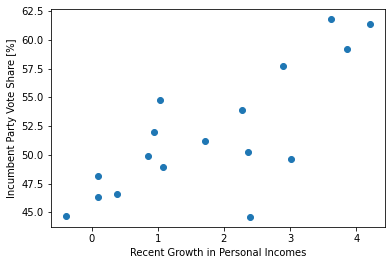

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df[incomes], df[votes])
plt.xlabel('Recent Growth in Personal Incomes')
plt.ylabel('Incumbent Party Vote Share [%]');

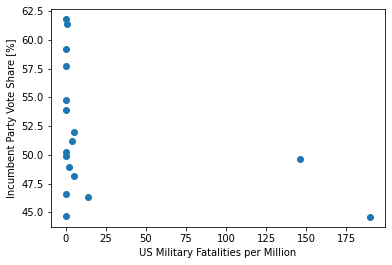

In [ ]:
plt.scatter(df[fatalities], df[votes])
plt.xlabel('US Military Fatalities per Million')
plt.ylabel('Incumbent Party Vote Share [%]');

# 2. Split Data

## 2.1 Split our **target vector** from our **feature matrix**

In [ ]:
y = df[votes]
X = df[[incomes, fatalities]]

## 2.2. Split our data into **training** and **test** sets

Two strategies:

- Random train-test split using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Generally we use 80% of the data for training, and 20% of the data for testing.
- If you have **timeseries**, then you need to do a "cutoff" split.

In [ ]:
# Train on data before 2008 and test on data 2008-present
cutoff = 2008
mask = X.index < 2008
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [ ]:
assert len(X) == len(X_train) + len(X_test)

# Establish Baseline

- **Q**: Is this a regression or a classification problem?
- **A**: Regression

In [ ]:
from sklearn.metrics import mean_absolute_error

y_pred = [y_train.mean()] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 4.846938775510204


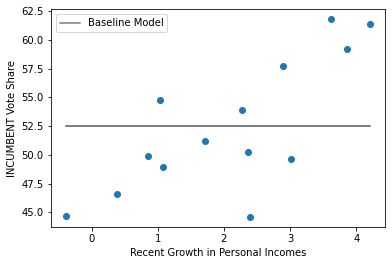

In [ ]:
col = 'Average Recent Growth in Personal Incomes'

plt.scatter(X_train[col], y_train)
plt.plot(X_train[col], 
         y_pred, 
         color='grey', 
         label='Baseline Model')
plt.xlabel('Recent Growth in Personal Incomes')
plt.ylabel('INCUMBENT Vote Share')
plt.legend();

# Build Model

To start, let's use one feature only.

In [ ]:
# Step 1: Import our predictor
from sklearn.linear_model import LinearRegression

# Step 2: Instantiate our predictor
model = LinearRegression()

# Step 3: Fit our model to the TRAINING DATA
model.fit(X_train[[col]], y_train)

# Step 4: Make predictions... see below


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Check Metrics

## Mean Absolute Error

In [ ]:
print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train[[col]])))
print('Testing MAE:', mean_absolute_error(y_test, model.predict(X_test[[col]])))

Training MAE: 2.645479454315596
Testing MAE: 1.7998717748375863


## Root Mean Squared Error

In [ ]:
from sklearn.metrics import mean_squared_error

print('Training RMSE:', mean_squared_error(y_train, model.predict(X_train[[col]]), squared=False))
print('Testing RMSE:', mean_squared_error(y_test, model.predict(X_test[[col]]), squared=False))

Training RMSE: 3.6773568396257406
Testing RMSE: 2.180652086836372


## $R^2$

In [ ]:
from ipywidgets import interactive, IntSlider, FloatSlider
from math import floor, ceil
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class BruteForceRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, m=0, b=0):
        self.m = m
        self.b = b
        self.mean = 0
        
    def fit(self, X, y):
        self.mean = np.mean(y)
        return self
    
    def predict(self, X, return_mean=True):
        if return_mean:
            return [self.mean] * len(X)
        else:
            return X * self.m + self.b

def plot(slope, intercept):
    # Assign data to variables
    x = df['Average Recent Growth in Personal Incomes']
    y = df['Incumbent Party Vote Share']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    
    # Set ax limits
    mar = 0.2
    x_lim = floor(x.min() - x.min()*mar), ceil(x.max() + x.min()*mar)
    y_lim = floor(y.min() - y.min()*mar), ceil(y.max() + y.min()*mar)
    
    # Instantiate and train model
    bfr = BruteForceRegressor(slope, intercept)
    bfr.fit(x, y)
    
    # ax1   
    ## Plot data
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    ax1.scatter(x, y)
    
    ## Plot base model
    ax1.axhline(bfr.mean, color='orange', label='baseline model')
    
    ## Plot residual lines
    y_base_pred = bfr.predict(x)
    ss_base = mean_squared_error(y, y_base_pred) * len(y)
    for x_i, y_i, yp_i in zip(x, y, y_base_pred):
        ax1.plot([x_i, x_i], [y_i, yp_i], 
                 color='gray', linestyle='--', alpha=0.75)
    
    ## Formatting
    ax1.legend()
    ax1.set_title(f'Sum of Squares: {np.round(ss_base, 2)}')
    ax1.set_xlabel('Growth in Personal Incomes')
    ax1.set_ylabel('Incumbent Party Vote Share [%]')

    # ax2

    ax2.set_xlim(x_lim)
    ax2.set_ylim(y_lim)
    ## Plot data
    ax2.scatter(x, y)
    
    ## Plot model
    x_model = np.linspace(*ax2.get_xlim(), 10)
    y_model = bfr.predict(x_model, return_mean=False)
    ax2.plot(x_model, y_model, color='green', label='our model')
    for x_coord, y_coord in zip(x, y):
        ax2.plot([x_coord, x_coord], [y_coord, x_coord * slope + intercept], 
                 color='gray', linestyle='--', alpha=0.75)   
    
    ss_ours = mean_squared_error(y, bfr.predict(x, return_mean=False)) * len(y)
    
    ## Formatting
    ax2.legend()
    ax2.set_title(f'Sum of Squares: {np.round(ss_ours, 2)}')
    ax2.set_xlabel('Growth in Personal Incomes')
    ax2.set_ylabel('Incumbent Party Vote Share [%]')

y = df['Incumbent Party Vote Share']
slope_slider = FloatSlider(min=-5, max=5, step=0.5, value=0)
intercept_slider = FloatSlider(min=int(y.min()), max=y.max(), step=2, value=y.mean())
    
interactive(plot, slope=slope_slider, intercept=intercept_slider)

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0, step=0.5), FloatSlider(va…

In [ ]:
from sklearn.metrics import r2_score
print('Training R^2:', r2_score(y_train, model.predict(X_train[[col]])))
print('Testing R^2:', r2_score(y_test, model.predict(X_test[[col]])))

Training R^2: 0.5663905156461234
Testing R^2: 0.14809080764669635


# And finally... Multiple Linear Regression

In [ ]:
# Step 2: Instantiate our predictor
model2 = LinearRegression()

# Step 3: Fit our model to the TRAINING DATA
model2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('Training R^2:', model2.score(X_train, y_train))
print('Testing R^2:', model2.score(X_test, y_test))

Training R^2: 0.8739958896016927
Testing R^2: 0.3792995526663848


# Explain Model

In [ ]:
X_train.columns

Index(['Average Recent Growth in Personal Incomes', 'US Military Fatalities per Million'], dtype='object')

In [ ]:
model2.coef_

array([ 3.59004735, -0.05315709])

In [ ]:
model2.intercept_

46.25489966153873